# UNet for SuperResolution (Pytorch)
For the course of Artificial Intelligence II<br>
CIMAT <br>
 <br>
 Structure:<br>
 1. Prepare training images based on STL-10 dataset
 2. Create & Train model
 3. Load trained weight



#### Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
#import torchvision.transforms as transforms
from torch.autograd import Variable
#para dataset stl10
import torchvision.datasets as ds

from matplotlib import image

from unetSR import UNet

## Preprocessing training images
Creating patches of smaller dimensions to train the net (reducing STL10 data from 96x96 to 48x48)

In [2]:
stl10ds = ds.STL10('./data', split='unlabeled', download=True)
imgs = stl10ds.data[:15000] #picks a slice of the dataset to train
imgs = torch.from_numpy(imgs).type(torch.LongTensor)/255.
imgs_y = imgs
imgs_x = nn.functional.interpolate(imgs,size=[48,48])
train = torch.utils.data.TensorDataset(imgs_x,imgs_y)

Files already downloaded and verified


Text(0.5, 1.0, 'Original size 96x96')

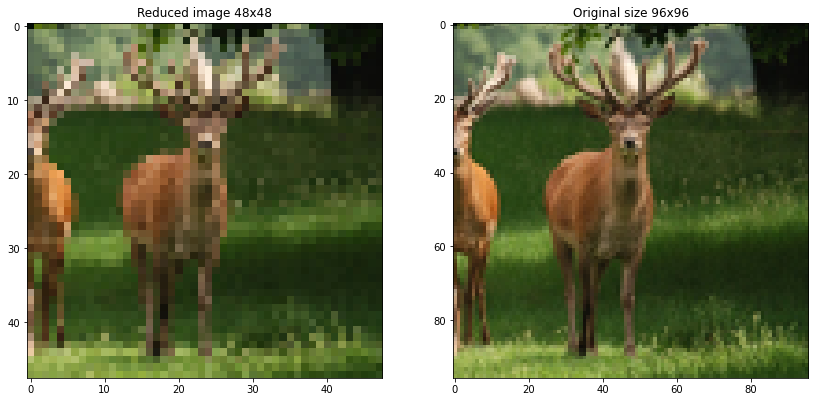

In [3]:
#images with reduced dimensions
idx = 10
tmpx=imgs_x[idx].permute(1,2,0)
tmpy=imgs_y[idx].permute(1,2,0)
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(tmpx)
plt.title('Reduced image 48x48')
plt.subplot(1,2,2)
plt.imshow(tmpy)
plt.title('Original size 96x96')

In [6]:
batch_size = 70
iters = 30000
num_epochs=int(iters/(len(imgs_x)/batch_size))

In [7]:
train_loader= torch.utils.data.DataLoader(train,batch_size=batch_size,shuffle=True) 

## Unet

In [8]:
model = UNet(in_ch=3,out_ch=3)
#Use GPU if is available
if torch.cuda.is_available():
    model.cuda()

In [9]:
error = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.002,betas=(0.9,0.999),weight_decay=0.00001)

In [ ]:
import time 
tic = time.time()
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in range(num_epochs):
    for i,(imgs_x,imgs_y) in enumerate (train_loader):
        
        train = Variable(imgs_x.view(-1,3,48,48)).cuda() 
        test = Variable(imgs_y.view(-1,3,96,96)).cuda() 

        optimizer.zero_grad() #borra el gradiente
        outputs = model(train) #propagacion
        loss = error(outputs,test) #calcula el error
        loss.backward()    #retropropaga error
        optimizer.step()   #actualiza los parámetros
        count +=1
        
        if count%50 ==0:
            iteration_list.append(count)
            loss_list.append(loss.item())
            print('iter:{} loss:{}'.format(count,loss.data))
print('elapsed = ',time.time()-tic)

iter:50 loss:0.09217177331447601
iter:100 loss:0.07201389968395233
iter:150 loss:0.05614808201789856
iter:200 loss:0.050279952585697174
iter:250 loss:0.05375519022345543
iter:300 loss:0.04782424122095108
iter:350 loss:0.047707654535770416
iter:400 loss:0.04740387946367264
iter:450 loss:0.04071037843823433
iter:500 loss:0.04121201112866402
iter:550 loss:0.04637317359447479
iter:600 loss:0.039398737251758575
iter:650 loss:0.041402705013751984
iter:700 loss:0.04192838445305824
iter:750 loss:0.03723014518618584
iter:800 loss:0.0380546860396862
iter:850 loss:0.0382821224629879
iter:900 loss:0.03365501016378403
iter:950 loss:0.03729407489299774


In [ ]:
plt.plot(iteration_list,loss_list)

In [ ]:
torch.save(model.state_dict(),'unet_final_2.pt')

### Predicción

In [32]:
#carga modelo:
model2 = UNet(3,3)
model2.load_state_dict(torch.load('unet_final_1.pt'))
model2.eval()
if torch.cuda.is_available():
    model2.cuda()

UNet(
  (in_layer): inconv(
    (up): Upsample(scale_factor=2.0, mode=bilinear)
    (conv): doubleconv2d(
      (doubleconv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
  )
  (down1): Down(
    (down): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): doubleconv2d(
        (doubleconv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU(inplace=True)
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): ReLU(inplace=True)
        )
      )
    )
  )
  (down2): Down(
    (down): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): doubleconv2d(
        (doubleconv): Se

In [34]:
img=image.imread('data/koko.jpg')

In [36]:
imgTest = torch.from_numpy(np.copy(img)).type(torch.LongTensor)
imgTest = imgTest.permute(2,0,1)
channels,wTest,hTest = imgTest.shape
imgTest = (imgTest/255.).view(-1,3,wTest,hTest)

In [37]:
imgTest_x =  nn.functional.interpolate(imgTest,size=[wTest//2,hTest//2])

Text(0.5, 1.0, 'original')

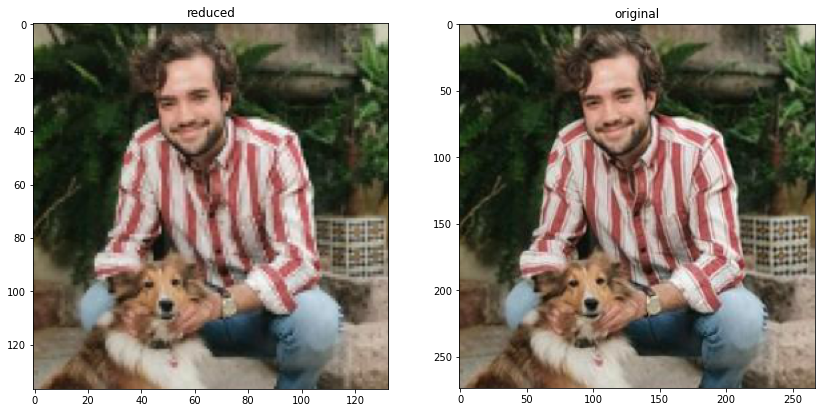

In [45]:
tmpx=imgTest_x.permute(0,2,3,1)
tmpy=imgTest.permute(0,2,3,1)
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(tmpx[0])
plt.title('reduced')
plt.subplot(1,2,2)
plt.imshow(tmpy[0])
plt.title('original')

In [39]:
x_totrain = Variable(imgTest_x)
if torch.cuda.is_available():
    x_totrain.cuda()
    
yhat2 = model2(x_totrain)

In [40]:
if torch.cuda.is_available():
    yhat2=yhat2.cpu().detach()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'upscaled')

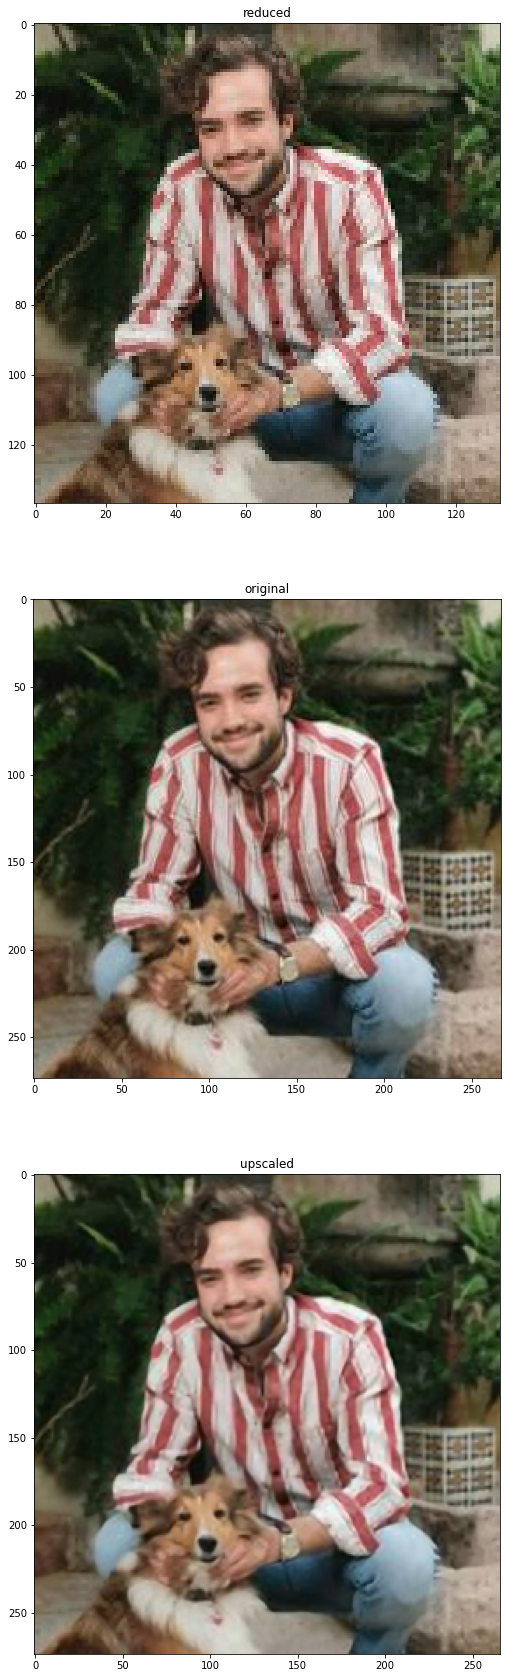

In [44]:
#Plotting resulting image
tmphat=yhat2.permute(0,2,3,1)
plt.figure(figsize=(10,30))
plt.subplot(3,1,1)
plt.imshow(tmpx[0])
plt.title('reduced')
plt.subplot(3,1,2)
plt.imshow(tmpy[0])
plt.title('original')
plt.subplot(3,1,3)
plt.imshow(tmphat[0])
plt.title('upscaled')